# Windowed mean analysis
This notebook shows the most simple analysis. It introduces the concept of a windowed mean, where two conditions are compared by taking the mean of the signal in a certain time window in relevant sensors and comparing the means. This includes some basic plotting and statistical testing using the t-test.


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne

In [2]:
# load in the data
all_epochs = []
# relative path to the data 2 directories up
data_path = Path(Path.cwd()).parents[1] / "data" / "preprocessed"

for participant in ["Group1", "Group5", "Group6"]:
    epochs = mne.read_epochs(data_path / f"{participant}-epo.fif", verbose=False, preload=True)

    all_epochs.append(epochs)


print(type(all_epochs)) # we have now created a list of epochs objects
print(len(all_epochs)) # we have 3 epochs objects in the list
print(type(all_epochs[0])) # we can access the first epochs object in the list which is a Epochs object

<class 'list'>
3
<class 'mne.epochs.EpochsFIF'>


## Single participant analysis
First, we will do the analysis on one participant. For the purpose of this notebook, we will contrast correct and incorrect button presses.

In [3]:
epochs_participant1 = all_epochs[0]

# extract the trials you are interested in
epochs_incorrect = epochs_participant1["Incorrect"] # all the button presses for incorrect trials
epochs_correct = epochs_participant1["Correct"] # all the button presses for correct trials

Now we have our two conditions: Correct and incorrect button presses. One of the simplest way in which we can determine whether the signal in our two conditions are statistically significant is by:

1. Segmenting our data using only certain channels in a specific time window. Keep in mind that which time window and channels should be established a priori, for instance according to the literature.

2. Taking the mean of that window across channels and and samples.

3. Running statistical tests on the windowed means from the two conditions.

In an experiment with multiple participants we would also average over trials from individual participants, in order to only have one data point per participant (and thereby avoid multiple comparisons). However, since we have one participant (for now), we can keep one dimension of the individual data, i.e. the trials.

If you are conducting a windowed mean analysis, you should rely on previous literature to determine which channels and time windows to use. 

**Note:** This example is just showing how to calculate the windowed mean and run a statistical test on it - and I have chosen the channels and time window arbitrarily.

### Preparing the data for t-test
The aim is to conduct a t-test on the averaged data over the chosen channels and timepoints, to establish whether the means of the two groups (correct and incorrect) are different.

We can use the `get_data()` function to get the numerical values of the signal (in microvolts) for the t-test. tmin and tmax are used to define the time window, and the picks are the channels that we expect to see an effect in.

In [4]:
# names of the channels you want to look at
picks = ["Fz", "Cz", "Pz", "Oz"]


# time window (remember to write it in seconds!!)
tmin = 0.2
tmax = 0.4

In [5]:
data_incorrect = epochs_incorrect.get_data(picks = picks, tmin = tmin, tmax = tmax)
data_correct = epochs_correct.get_data(picks = picks, tmin = tmin, tmax = tmax)

Investigating the resulting data; how many dimensions does the data have? What do you think they represent (i.e. which dimension is channels, trials, etc.)? Is there a difference in the number of trials between the two conditions?

In [6]:
print(data_incorrect.shape)
print(data_correct.shape)

(15, 4, 50)
(45, 4, 50)


Now we can average over the time window and channels, to get one data point per trial. We can use the `np.mean()` function to do this, and specify the axis over which to average. 

In [7]:
data_incorrect_mean = np.mean(data_incorrect, axis=2) # averaging over the third dimension of the data (time)
print(data_incorrect_mean.shape)

data_incorrect_mean = np.mean(data_incorrect_mean, axis=1) # averaging over the second dimension of the data (channels)
print(data_incorrect_mean.shape)

# you can also do this in one line
data_correct_mean = np.mean(data_correct, axis=(1,2)) # averaging over the second and third dimension of the data (channels and time)
print(data_correct_mean.shape)

(15, 4)
(15,)
(45,)


### Running the t-test

In [8]:
from scipy import stats

In [9]:
stats.ttest_ind(data_correct_mean, data_incorrect_mean)

Ttest_indResult(statistic=-0.6223877700899523, pvalue=0.5361262213332723)

### Plotting the results
Now lets create a plot of the time courses averaged over time and channels, where we also plot the time window that we used for the t-test.

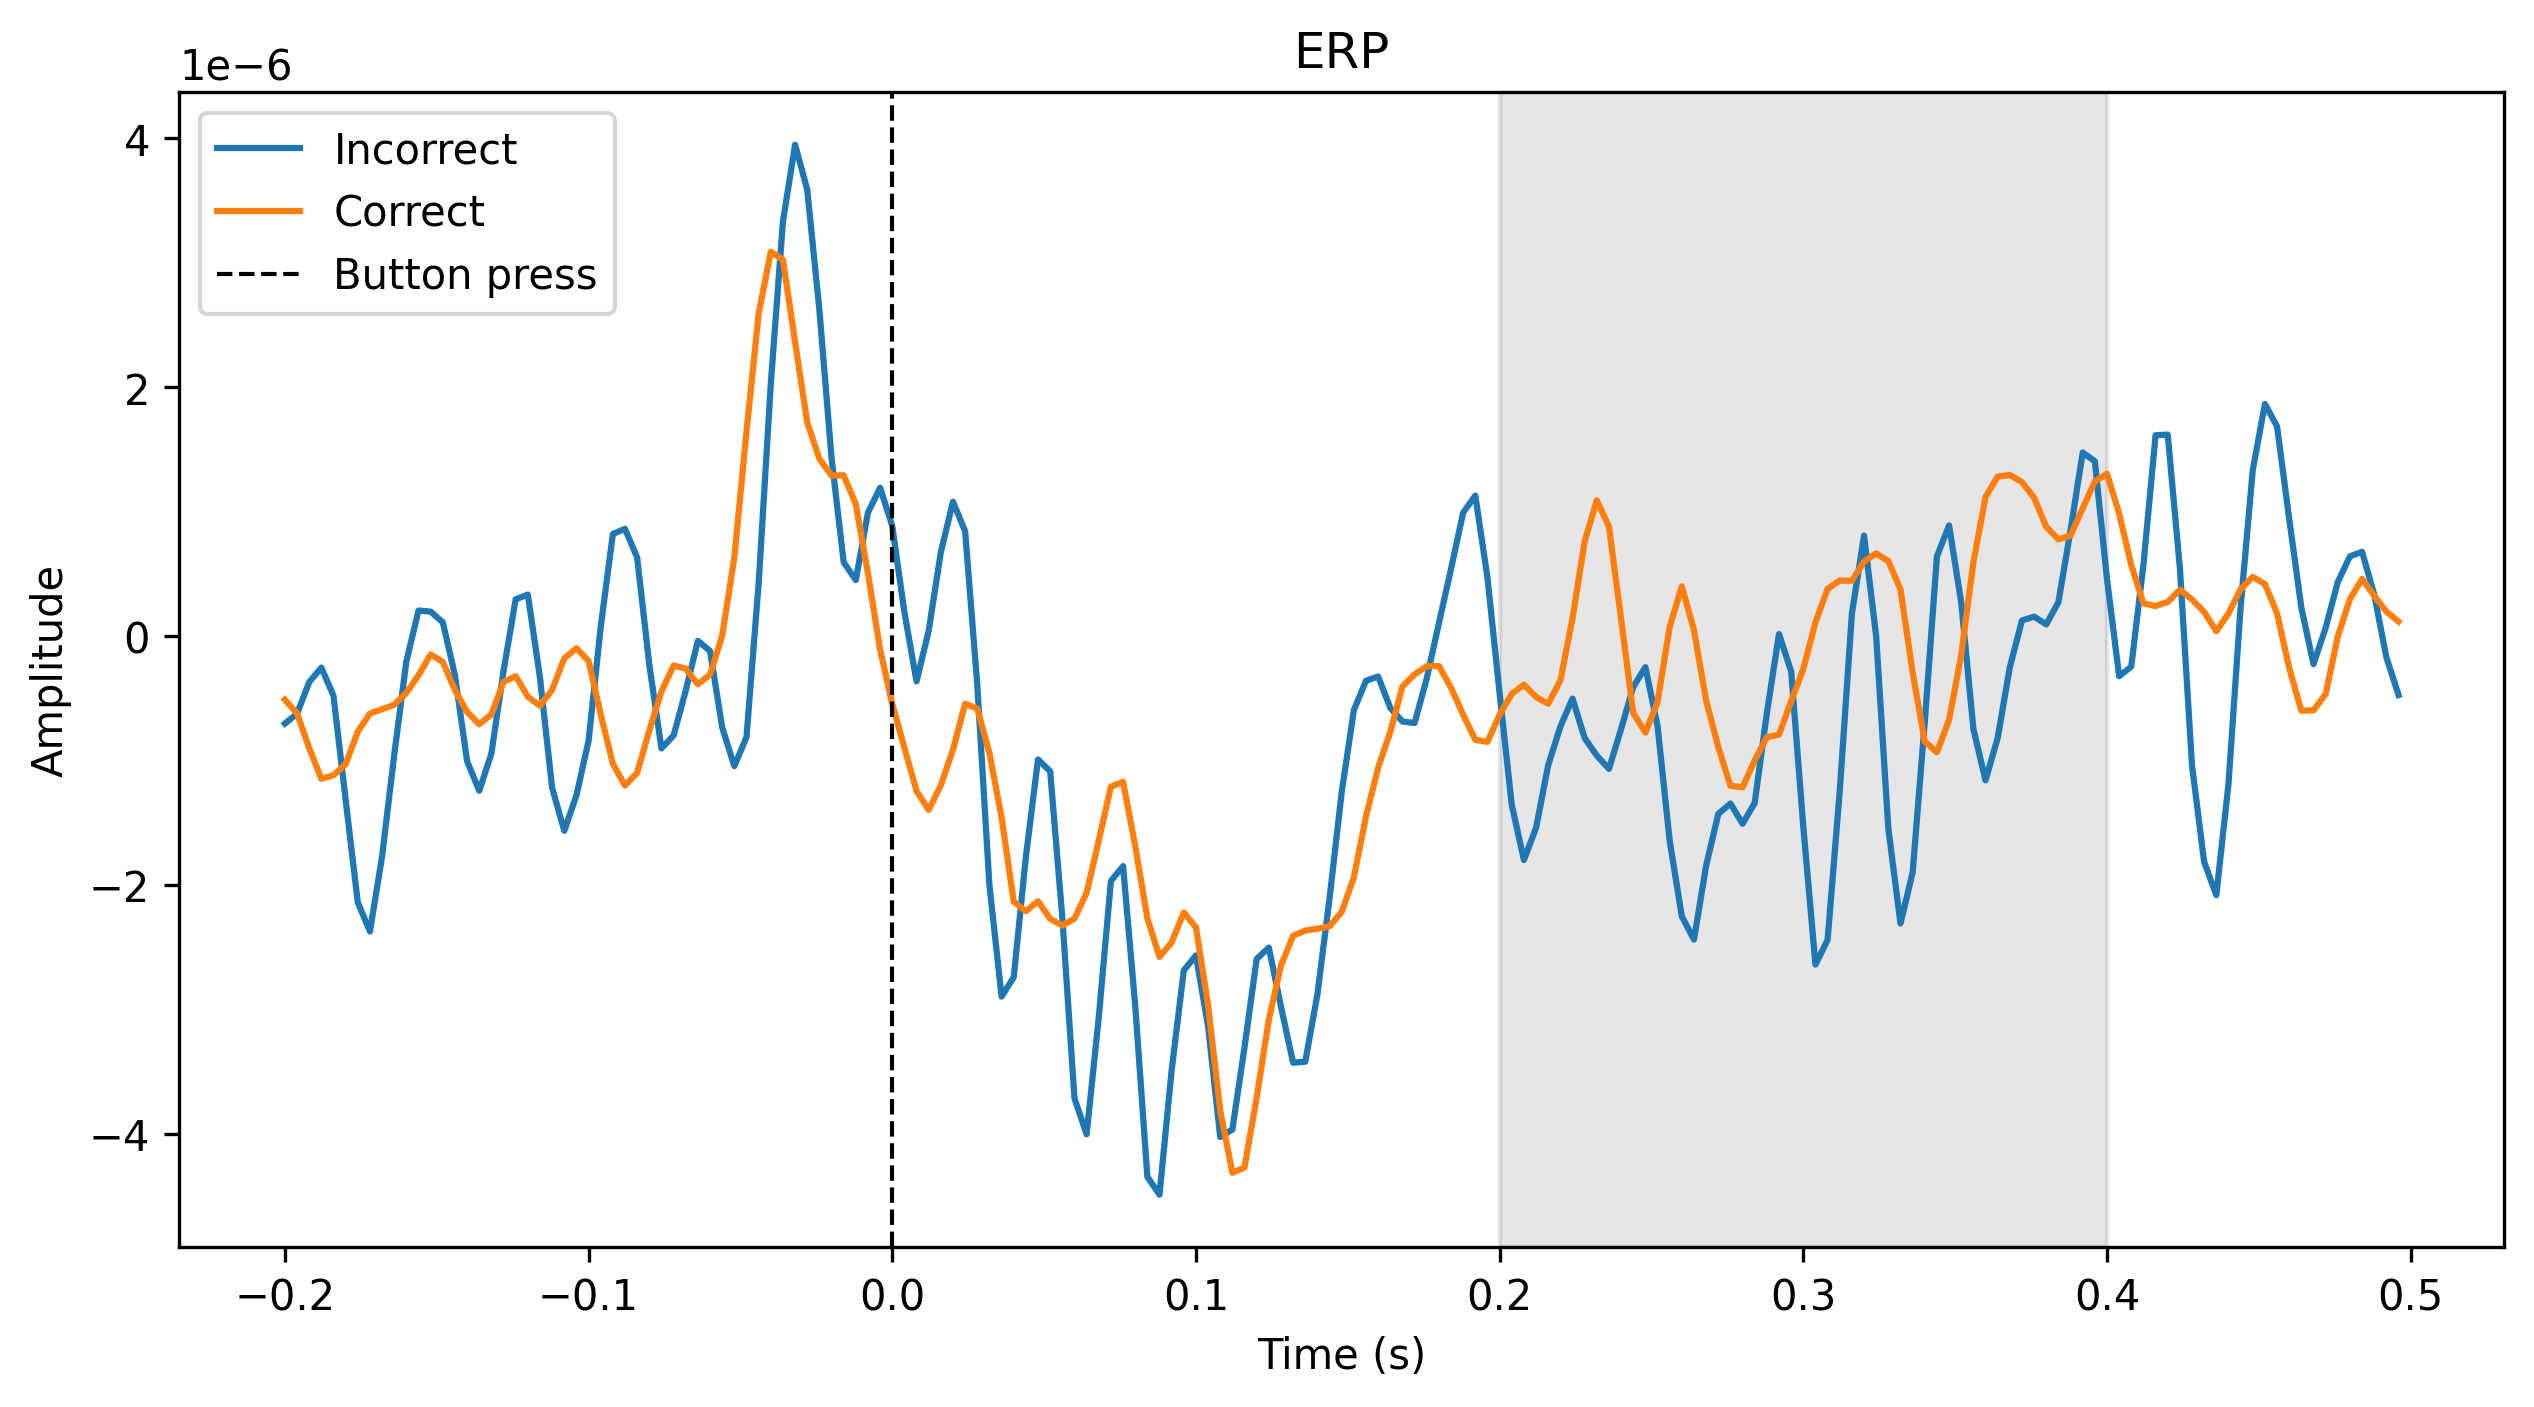

In [10]:
plot_data_incorrect = epochs_incorrect.get_data().mean(axis=(0, 1))
plot_data_correct = epochs_correct.get_data().mean(axis=(0, 1))

times = epochs_incorrect.times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

# plot the time course
ax.plot(times, plot_data_incorrect.T, label="Incorrect")
ax.plot(times, plot_data_correct.T, label="Correct")

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", label = "Button press", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP")
ax.legend()

## Multiple participant analysis
Now we will do the same analysis, but for all participants. We will use the same time window and channels as before, but we will average over trials for each participant, so that we only have one data point per participant.

### Preparing the data for t-test

In [11]:
incorrect = np.array([])
correct = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_incorrect = epochs["Incorrect"]
    epochs_correct = epochs["Correct"]

    # extract the data for the time window and channels of interest
    data_incorrect = epochs_incorrect.get_data(picks = picks, tmin = tmin, tmax = tmax)
    data_correct = epochs_correct.get_data(picks = picks, tmin = tmin, tmax = tmax)

    # calculate the mean over the time, channel and trial dimension (axis 0, 1 and 2)
    data_incorrect_mean = np.mean(data_incorrect, axis=(0, 1, 2))
    data_correct_mean = np.mean(data_correct, axis=(0, 1, 2))

    # append the data to the arrays
    incorrect = np.append(incorrect, data_incorrect_mean)
    correct = np.append(correct, data_correct_mean)

print(correct)
print(incorrect)

[-2.71728994e-06 -3.74876984e-07  2.27072720e-06]
[-1.99023299e-06 -4.93857819e-07  1.70468380e-06]


Now we have two datapoints per participant, one for each condition. We can use the `scipy.stats.ttest_rel()` function to run a paired t-test on the data. This function takes two arrays of data, and returns the t-value and p-value.

In [12]:
# now using paired t-test
stats.ttest_rel(correct, incorrect)

TtestResult(statistic=-0.036952267193895556, pvalue=0.9738797163818266, df=2)

### Plotting the results


In [13]:
# prep data for plotting
incorrect = np.array([])
correct = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_incorrect = epochs["Incorrect"]
    epochs_correct = epochs["Correct"]

    # extract the data for the time window and channels of interest
    data_incorrect = epochs_incorrect.get_data(picks = picks)
    data_correct = epochs_correct.get_data(picks = picks)

    # calculate the mean over the channel and trial dimension (axis 1 and 2)
    data_incorrect_mean = np.mean(data_incorrect, axis=(0, 1))
    data_correct_mean = np.mean(data_correct, axis=(0, 1))
    print(data_incorrect_mean.shape)

    # append the data to the arrays
    incorrect = np.concatenate((incorrect, data_incorrect_mean), axis=0)
    correct = np.concatenate((correct, data_correct_mean), axis=0)

print(correct.shape)
print(incorrect.shape)

# reshape the data to (participant, time)
incorrect = incorrect.reshape(3, 175)
correct = correct.reshape(3, 175)

print(correct.shape)
print(incorrect.shape)

(175,)
(175,)
(175,)
(525,)
(525,)
(3, 175)
(3, 175)


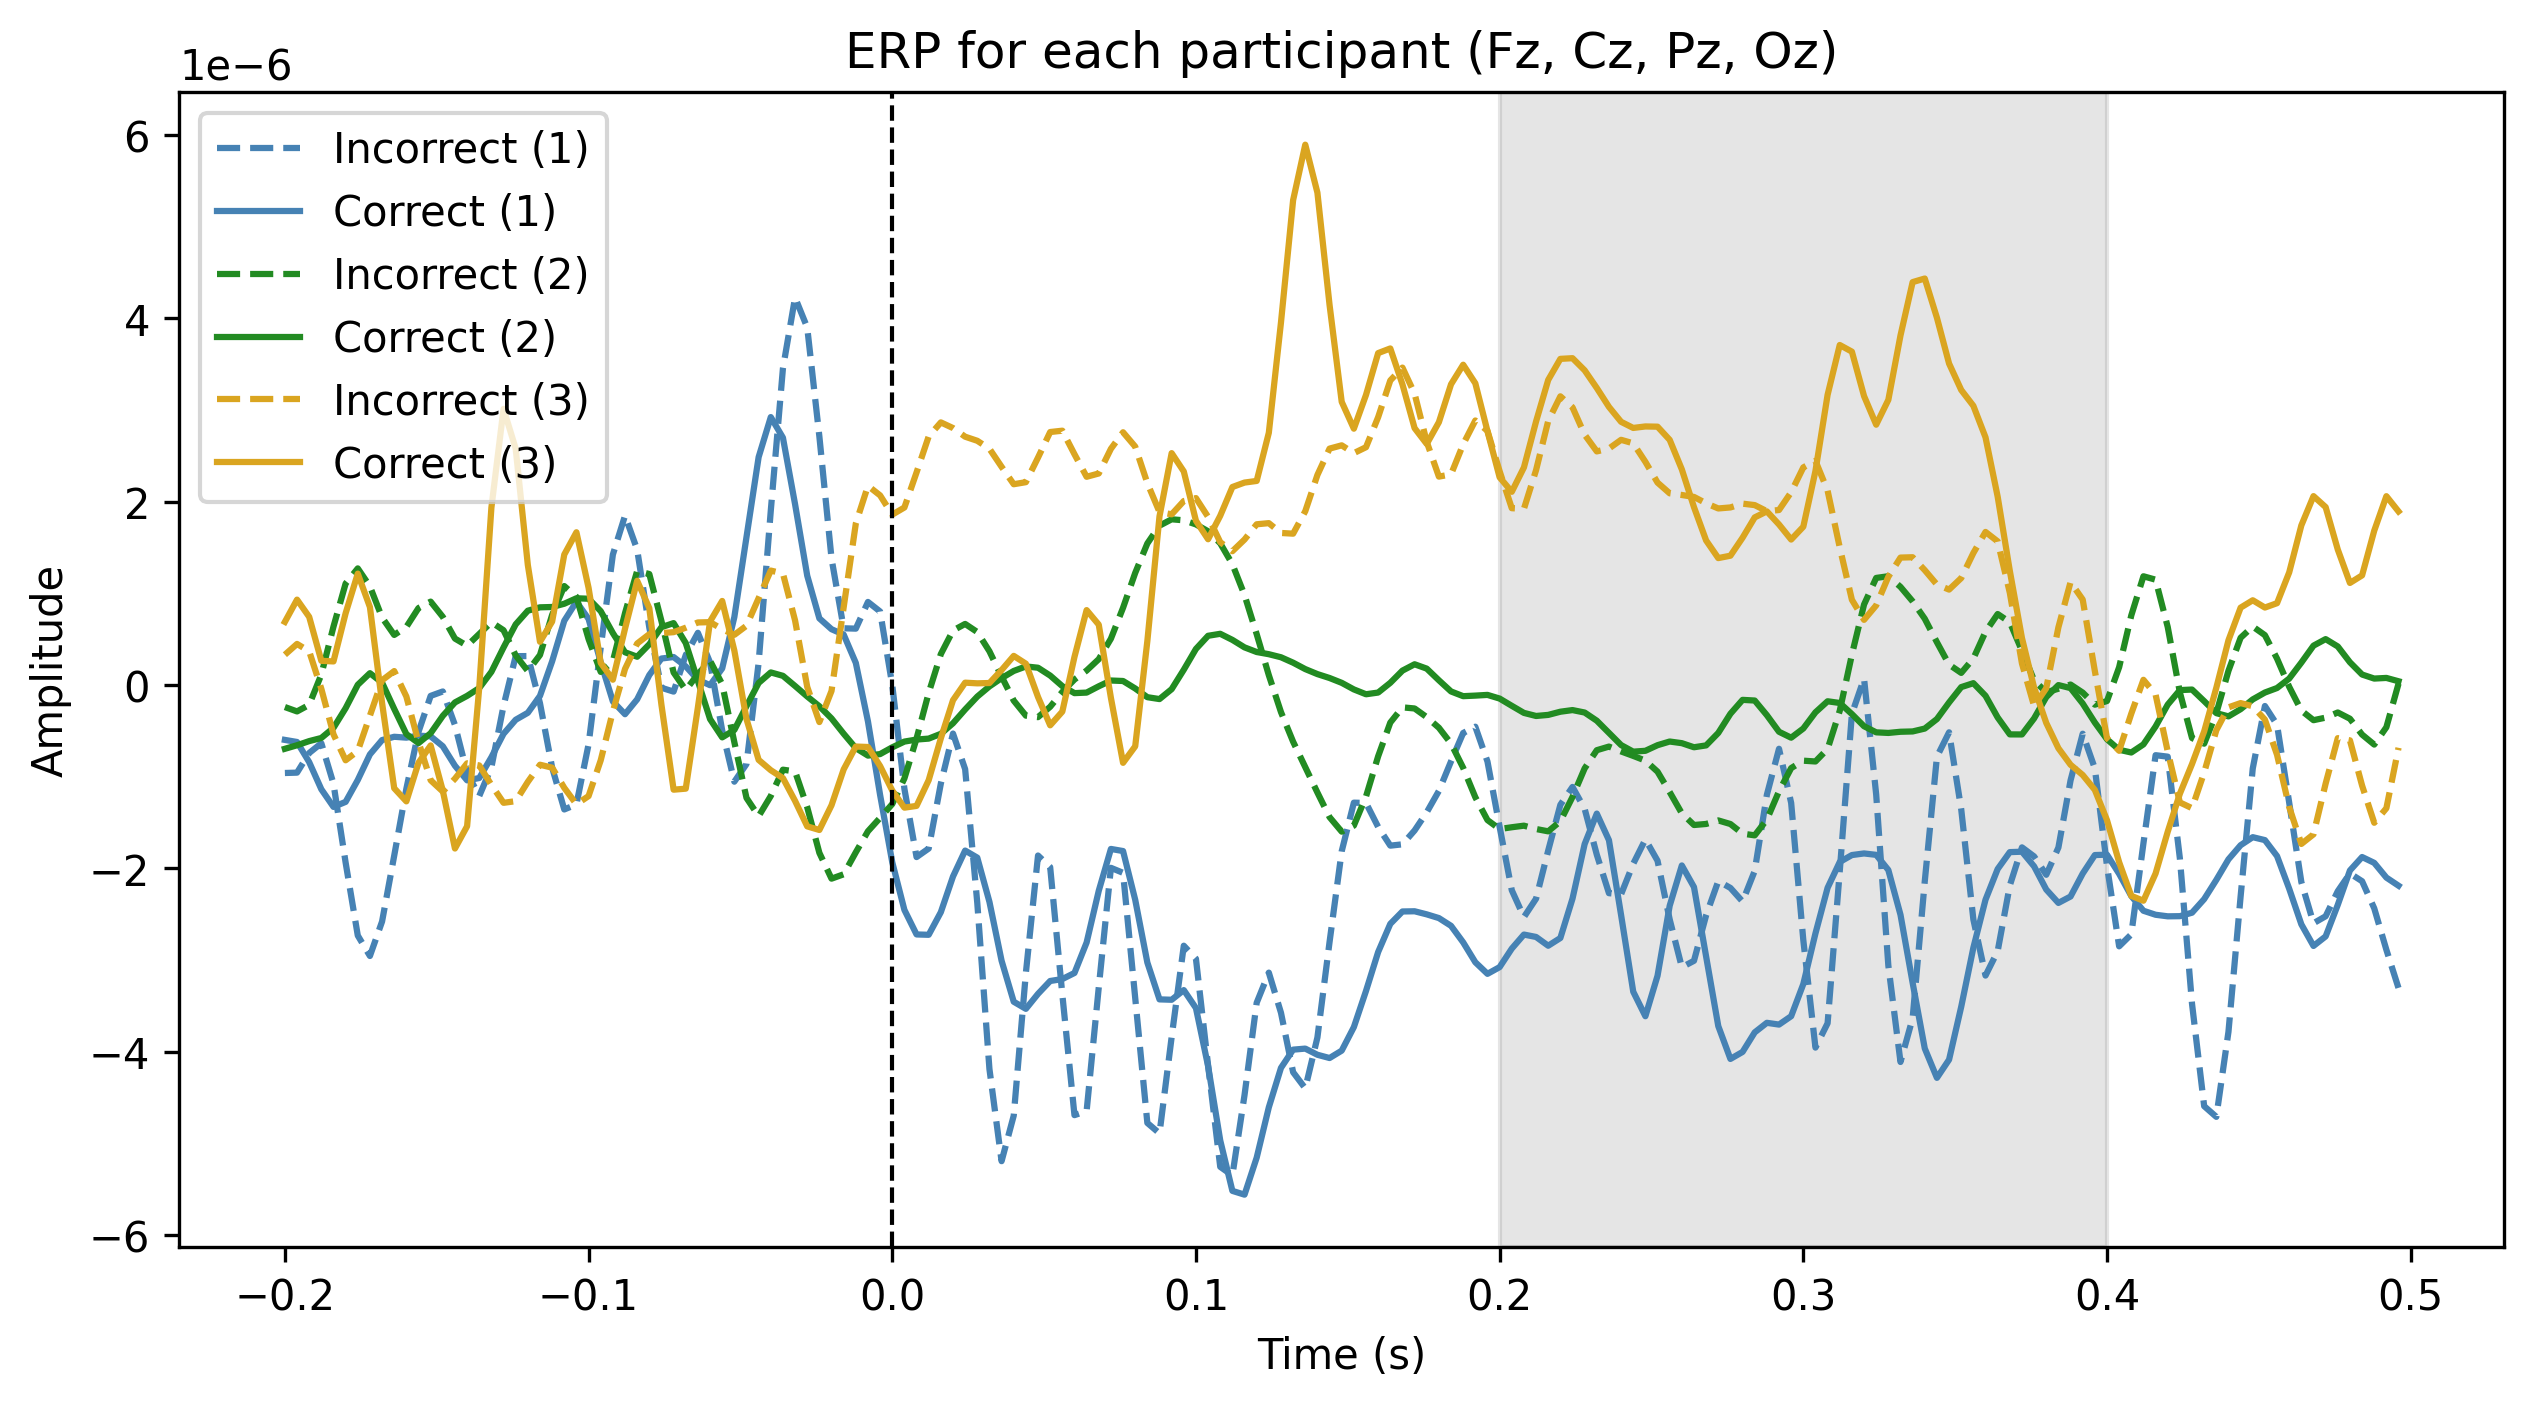

In [14]:

colours = ["steelblue", "forestgreen", "goldenrod"]

times = all_epochs[0].times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

for participant in range(3):
    # plot the time courses for each participant
    ax.plot(times, incorrect[participant, :], label=f"Incorrect ({participant+1})", linestyle="--", color=colours[participant])
    ax.plot(times, correct[participant, :], label=f"Correct ({participant+1})", linestyle="-", color=colours[participant])

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP for each participant (Fz, Cz, Pz, Oz)")
ax.legend()

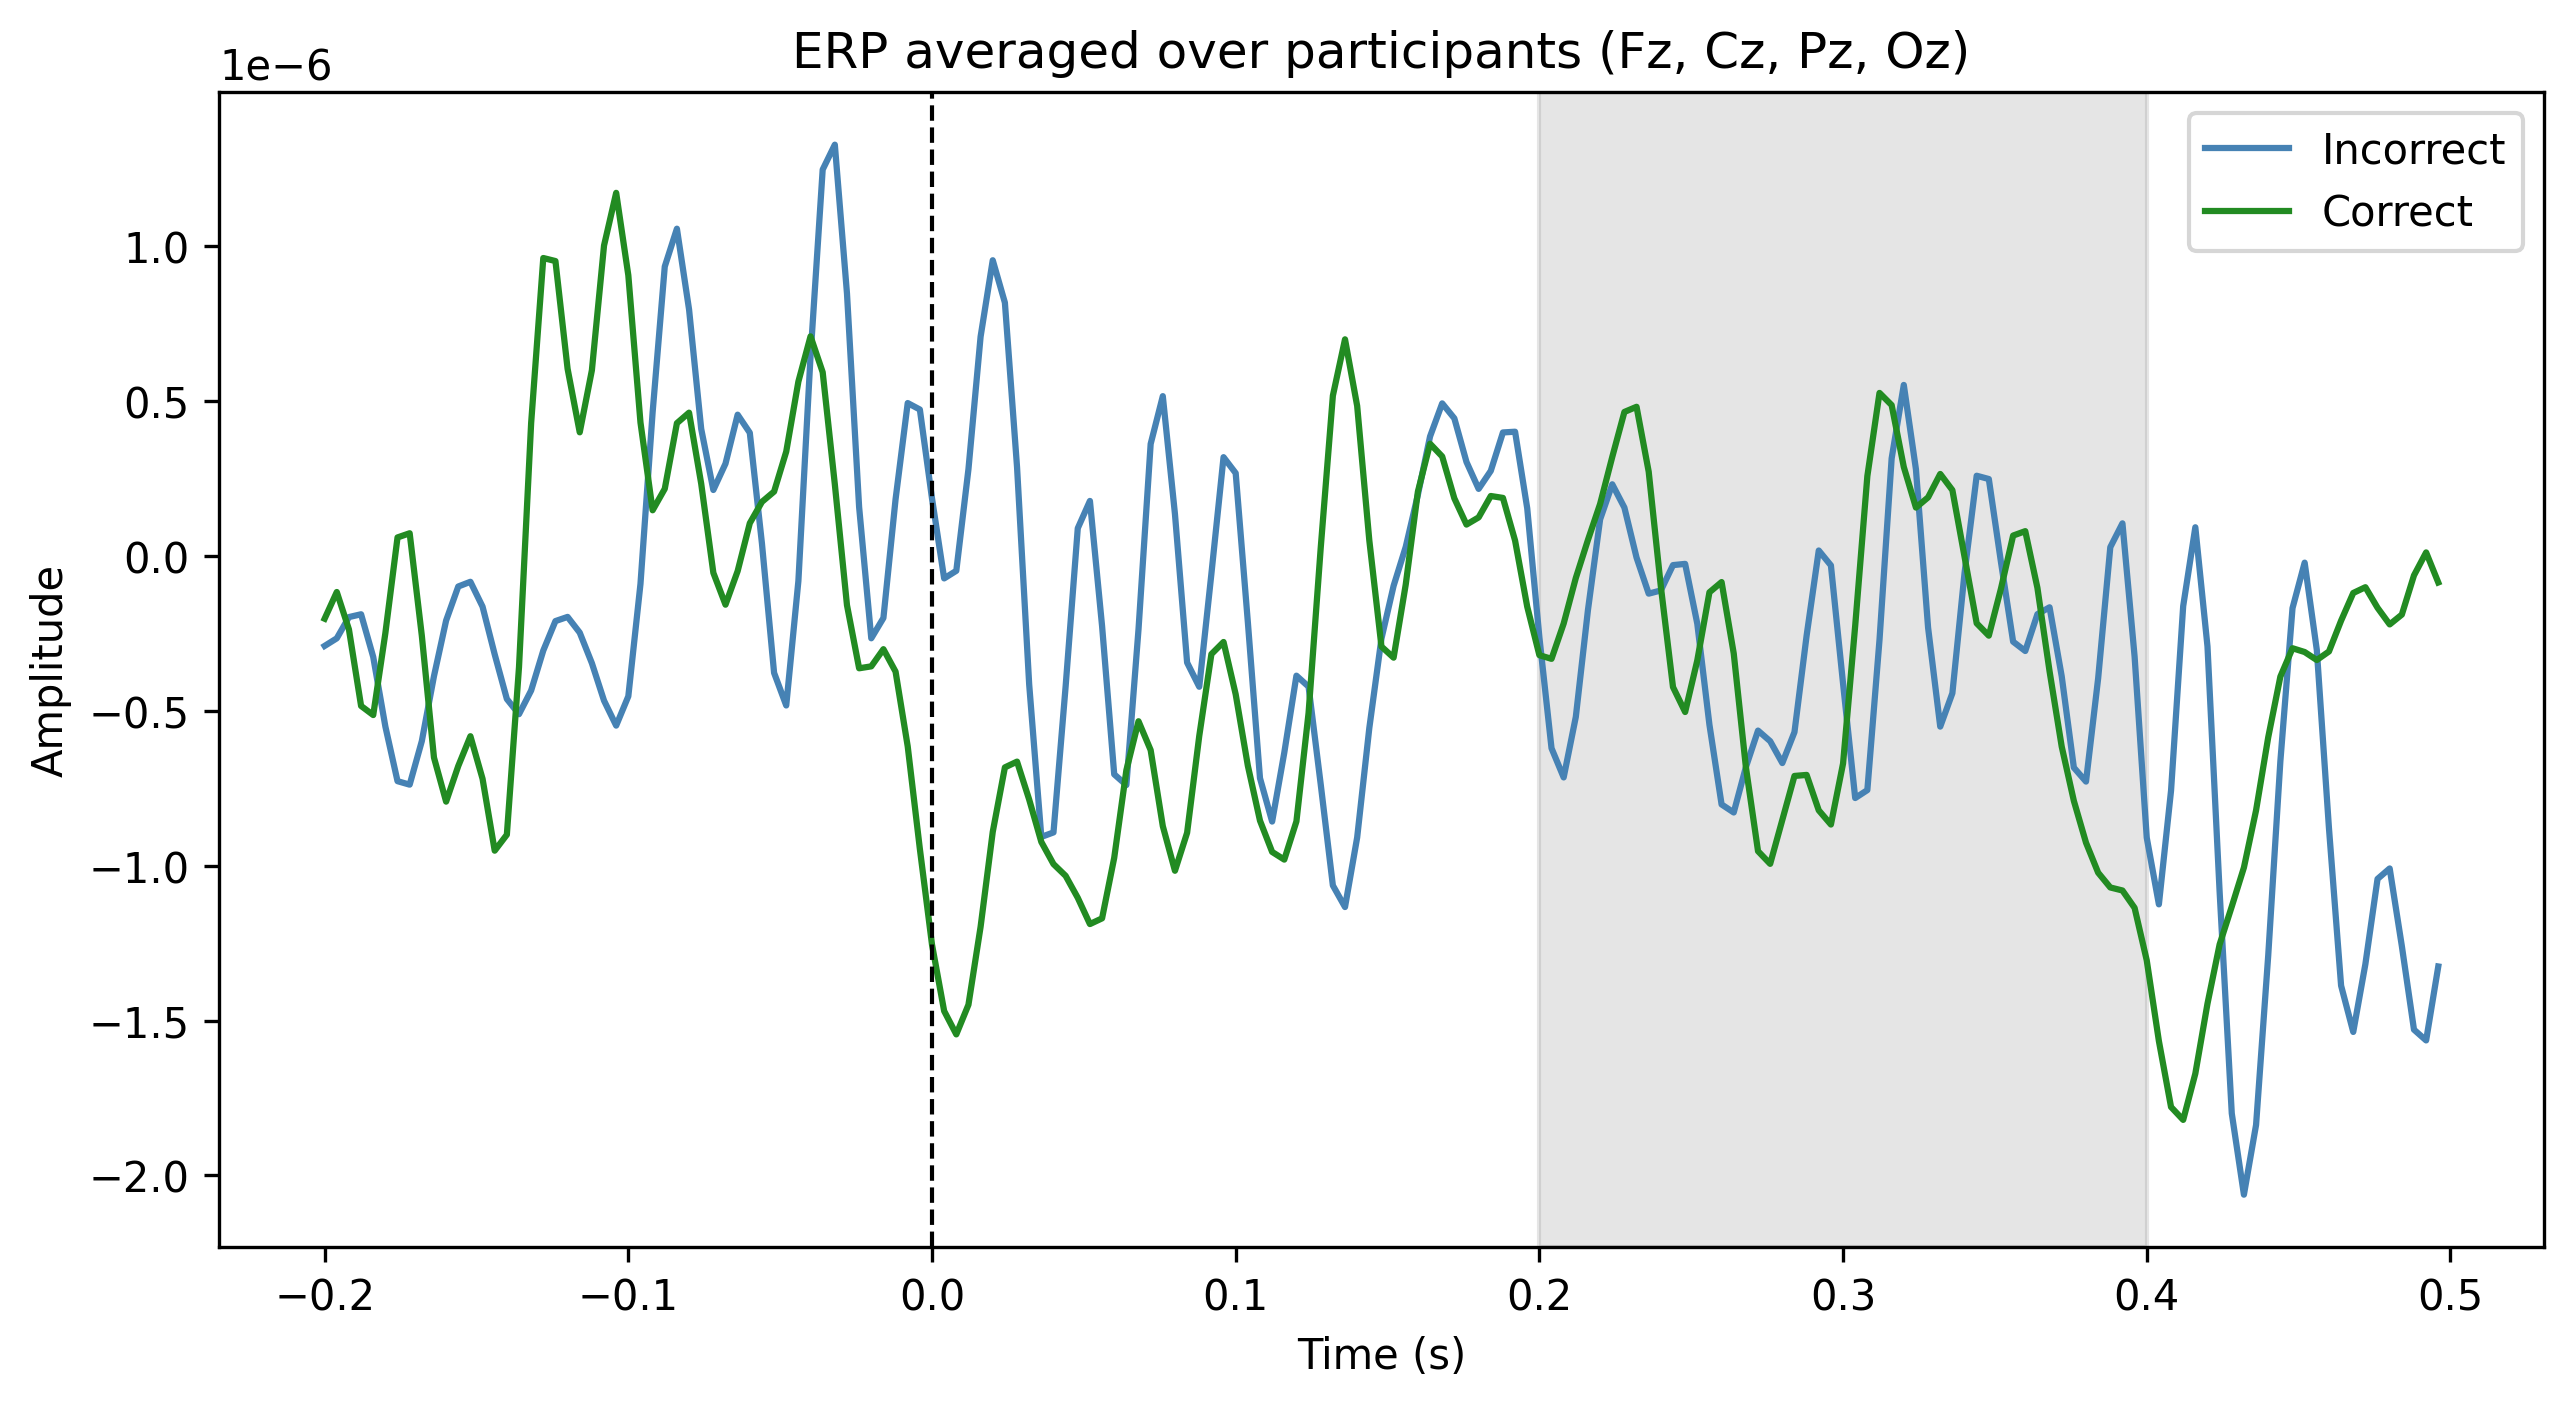

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

ax.plot(times, incorrect.mean(axis=0), label="Incorrect", linestyle="-", color=colours[0])
ax.plot(times, correct.mean(axis=0), label="Correct", linestyle="-", color=colours[1])

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP averaged over participants (Fz, Cz, Pz, Oz)")
ax.legend()